# 데이터셋

In [16]:
import pandas as pd

# 엑셀 파일 로드
file_path = '/content/musma+manual+crawling.xlsx'
data = pd.read_excel(file_path)

# 데이터의 처음 몇 행을 확인
data.head()
data.shape

(271, 4)

### 데이터 전처리

In [17]:
# 데이터셋을 재구성하기 위해 각 카테고리 별로 데이터를 하나의 리스트에 저장합니다.
# 각 뉴스 제목에 해당 카테고리의 레이블을 부여합니다.

# 카테고리를 레이블로 매핑
categories = data.columns
label_map = {category: i for i, category in enumerate(categories)}

# (뉴스 제목, 레이블) 형식의 리스트 생성
news_data = []
for category in categories:
    news_titles = data[category].dropna().tolist()  # NaN 값 제거
    news_data.extend([(title, label_map[category]) for title in news_titles])

# 데이터셋을 DataFrame으로 변환
news_df = pd.DataFrame(news_data, columns=['news_title', 'label'])

news_df.head(), label_map

(                                  news_title  label
 0           산업재해 자기규율 예방체계 구축…고용부 법령정비추진반 가동      0
 1   교통안전공단, ICT 기반 자동차검사소 스마트 안전관리 시스템 개발 추진      0
 2    고용부, '스마트 안전장비 보급·확산사업' 첫 시행…최대 3천만원 지원      0
 3              국토안전관리원 "스마트 안전장비 지원 신청 받습니다"      0
 4  [종합] KCC건설 공사장서 또 근로자 사망…고용부, 중대재해법 조사 착수      0,
 {'안전/산업재해/중대재해처벌법 ': 0, '스마트건설/ESG 경영': 1, '스마트조선/ESG 경영': 2, 'IT 동향': 3})

In [18]:
!pip install transformers
!pip install torch

In [19]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from transformers import AdamW, get_linear_schedule_with_warmup
from tqdm import tqdm
import numpy as np

In [20]:
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertForSequenceClassification.from_pretrained('monologg/kobert', num_labels=4)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
# 뉴스 제목을 토큰화합니다.
input_ids = []
attention_masks = []

for news in news_df['news_title']:
    encoded_dict = tokenizer.encode_plus(
                        news,                      # 뉴스 제목을 인코딩
                        add_special_tokens = True, # 특수 토큰 추가
                        max_length = 64,           # 문장의 최대 토큰 수 설정
                        pad_to_max_length = True,  # 짧은 문장은 패딩으로 채움
                        return_attention_mask = True,   # 어텐션 마스크 반환
                        return_tensors = 'pt',     # 파이토치 텐서로 반환
                   )

    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

# 토큰화된 데이터를 파이토치 텐서로 변환합니다.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(news_df['label'].values)

# 훈련 세트와 검증 세트로 분할합니다.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, labels, random_state=2018, test_size=0.1)

# 데이터 로더를 생성합니다.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=32)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=32)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [22]:
# KoBERT 토크나이저와 모델을 로드
tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
model = BertForSequenceClassification.from_pretrained('monologg/kobert', num_labels=4)

# GPU 사용 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 학습 코드
epochs = 50
loss_values = []

# 옵티마이저 설정
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # 학습률
                  eps = 1e-8 # 0으로 나누는 것을 방지하기 위한 매우 작은 숫자
                )

# 총 훈련 스텝은 에폭 수와 배치 사이즈에 따라 결정
total_steps = len(train_dataloader) * epochs

# 학습률 스케줄러 설정
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Warmup 스텝
                                            num_training_steps = total_steps)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at monologg/kobert and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [23]:
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# 손실과 정확도, F1 점수를 기록할 리스트 초기화
loss_values = []
validation_accuracy = []
validation_f1_scores = []

In [24]:
for epoch_i in range(0, epochs):
    # 에폭당 학습
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    total_loss = 0
    model.train()

    for step, batch in enumerate(train_dataloader):
        # 배치를 GPU에 로드
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 초기화
        model.zero_grad()

        # 순전파
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        labels=b_labels)

        # 손실 얻기
        loss = outputs.loss
        total_loss += loss.item()

        # 역전파
        loss.backward()

        # 그래디언트 클리핑
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # 가중치 업데이트
        optimizer.step()

        # 학습률 감소
        scheduler.step()

    # 평균 손실 계산
    avg_train_loss = total_loss / len(train_dataloader)
    loss_values.append(avg_train_loss)
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    # 검증
    print("  Running Validation...")
    model.eval()
    # 변수 초기화
    total_eval_accuracy = 0
    total_eval_f1 = 0
    total_eval_examples = 0

    for batch in validation_dataloader:
        # 배치를 GPU에 로드
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # 그래디언트 계산을 하지 않도록 설정
        with torch.no_grad():
            # 순전파 진행
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask)

        # 로그트와 레이블을 CPU로 이동
        logits = outputs.logits
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # 출력 로그트의 가장 높은 점수를 받은 클래스를 예측값으로 선택
        preds = np.argmax(logits, axis=1)

        # 정확도 계산
        total_eval_accuracy += (preds == label_ids).mean()

        # F1 점수 계산
        total_eval_f1 += f1_score(label_ids, preds, average='weighted')

        # 처리한 예제 수 업데이트
        total_eval_examples += b_input_ids.size(0)

    # 평균 정확도 계산 및 기록
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    validation_accuracy.append(avg_val_accuracy)
    print("  Validation Accuracy: {0:.2f}".format(avg_val_accuracy))

    # 평균 F1 점수 계산 및 기록
    avg_val_f1 = total_eval_f1 / len(validation_dataloader)
    validation_f1_scores.append(avg_val_f1)
    print("  Validation F1 Score: {0:.2f}".format(avg_val_f1))

# 전체 학습 및 검증 과정에서의 평균 손실 및 정확도 계산
avg_loss_over_epochs = sum(loss_values) / len(loss_values)
avg_accuracy_over_epochs = sum(validation_accuracy) / len(validation_accuracy)
avg_f1_over_epochs = sum(validation_f1_scores) / len(validation_f1_scores)

print('================================')
print(f"Final Average Training Loss: {avg_loss_over_epochs:.2f}")
print(f"Final Average Validation Accuracy: {avg_accuracy_over_epochs:.2f}")
print(f"Final Average Validation F1 Score: {avg_f1_over_epochs:.2f}")
print("Training complete!")

# 모델 저장
# model.save_pretrained('/content/drive/MyDrive/Model')
# tokenizer.save_pretrained('/content/drive/MyDrive/Model')

======== Epoch 1 / 30 ========
  Average training loss: 1.35
  Running Validation...
  Validation Accuracy: 0.38
  Validation F1 Score: 0.30
======== Epoch 2 / 30 ========
  Average training loss: 1.25
  Running Validation...
  Validation Accuracy: 0.47
  Validation F1 Score: 0.38
======== Epoch 3 / 30 ========
  Average training loss: 1.15
  Running Validation...
  Validation Accuracy: 0.43
  Validation F1 Score: 0.41
======== Epoch 4 / 30 ========
  Average training loss: 1.09
  Running Validation...
  Validation Accuracy: 0.50
  Validation F1 Score: 0.50
======== Epoch 5 / 30 ========
  Average training loss: 0.99
  Running Validation...
  Validation Accuracy: 0.47
  Validation F1 Score: 0.46
======== Epoch 6 / 30 ========
  Average training loss: 0.94
  Running Validation...
  Validation Accuracy: 0.53
  Validation F1 Score: 0.54
======== Epoch 7 / 30 ========
  Average training loss: 0.83
  Running Validation...
  Validation Accuracy: 0.57
  Validation F1 Score: 0.57
======== Epoc

### 시각화

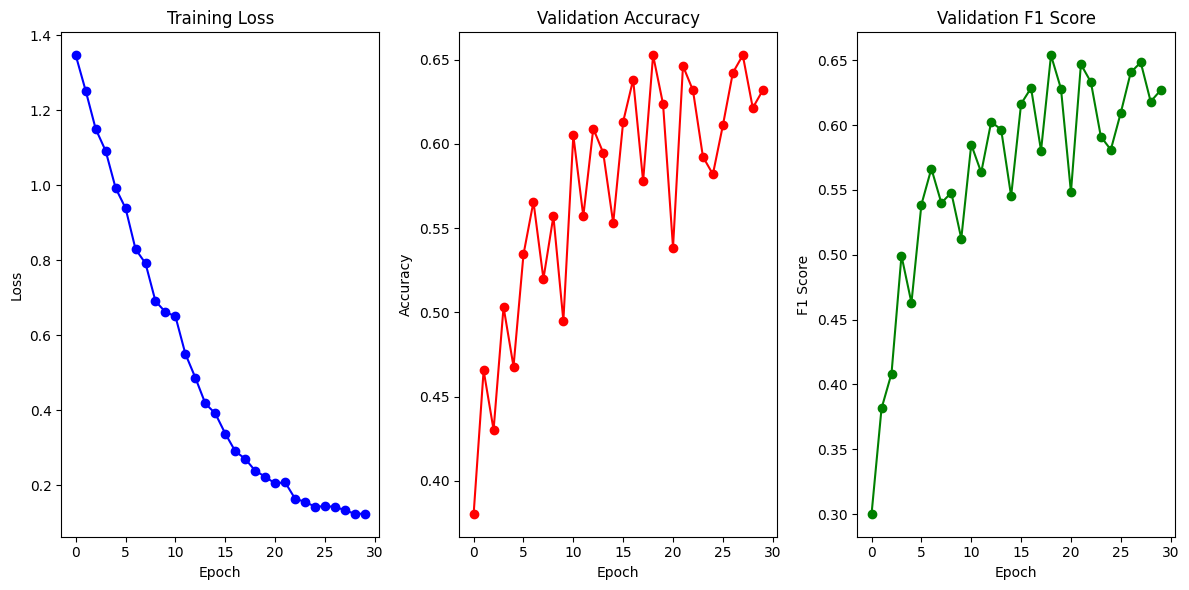

Training complete!


In [25]:
plt.figure(figsize=(12, 6))
# 학습 손실 그래프
plt.subplot(1, 3, 1)
plt.plot(loss_values, 'b-o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

# 검증 정확도 그래프
plt.subplot(1, 3, 2)
plt.plot(validation_accuracy, 'r-o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

# 검증 F1 점수 그래프
plt.subplot(1, 3, 3)
plt.plot(validation_f1_scores, 'g-o')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")

plt.tight_layout()
plt.show()

print("Training complete!")

In [26]:
# 파일 로드
file_path = '/content/news_titles.xlsx'
news_df = pd.read_excel(file_path)

# 'safety', 'industrialaccident', 'seriousdisaster' 열을 하나로 합치기
news_df['industrial_policy_trends'] = news_df['safety'].astype(str) + news_df['industrialaccident'].astype(str) + news_df['seriousdisaster'].astype(str)

# 불필요한 열 제거
news_df = news_df.drop(columns=['safety', 'industrialaccident', 'seriousdisaster'])

# 결과 확인 및 Excel 파일로 저장
saved_file_path = '/content/processed_news_titles.xlsx'
news_df.to_excel(saved_file_path, index=False)
saved_file_path

'/content/processed_news_titles.xlsx'